<b>Import dependencies</b>

In [1]:
import numpy as np
import copy 
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from data_processing import load_dataset

<b>Get datasets</b>

In [2]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

In [3]:
# overview the dataset

print(f'training data shape: {train_set_x_orig.shape}')
print(f'training label shape: {train_set_y_orig.shape}')
print(f'test data shape: {test_set_x_orig.shape}')
print(f'test label shape: {test_set_y_orig.shape}')
print(f'training data in total: {len(train_set_x_orig)}')
print(f'test data in total: {len(test_set_x_orig)}')
print(f'total classes: {classes}')

training data shape: (209, 64, 64, 3)
training label shape: (1, 209)
test data shape: (50, 64, 64, 3)
test label shape: (1, 50)
training data in total: 209
test data in total: 50
total classes: [b'non-cat' b'cat']


clearly, its b'non-cat'


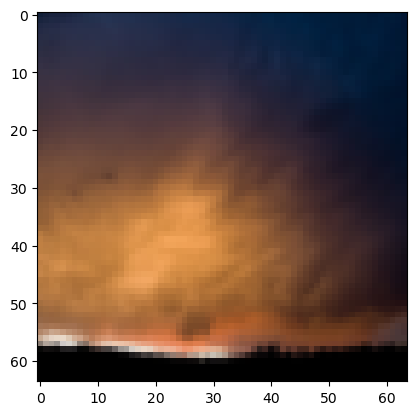

In [55]:
# check one example

index = 0
plt.imshow(train_set_x_orig[index])
print(f'clearly, its {classes[index]}')

In [5]:
# reshape the image 

train_set_x = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
train_set_y = train_set_y_orig.reshape(train_set_y_orig.shape[0], -1)
test_set_x = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
test_set_y = test_set_y_orig.reshape(test_set_y_orig.shape[0], -1)

In [6]:
print(f'training data shape: {train_set_x.shape}')
print(f'training label shape: {train_set_y.shape}')
print(f'test data shape: {test_set_x.shape}')
print(f'test label shape: {test_set_y.shape}')

training data shape: (12288, 209)
training label shape: (1, 209)
test data shape: (12288, 50)
test label shape: (1, 50)


In [7]:
# standardize dataset

train_set_x = train_set_x / 225.
test_set_x = test_set_x / 225.

<b>Build the Network</b>

<b>Helper functions</b>

In [8]:
def sigmoid(z):
    '''
    compute sigmoid of input
    
    Args:
    x -- numpy array
    
    return:
    fx -- numpy array
    '''
    
    return 1 / (1 + np.exp(-z))

In [9]:
# test sigmoid function

z = np.random.randn(1,3)
print(f'sigmoid of z: {sigmoid(z)}')

sigmoid of z: [[0.65969652 0.44941524 0.6858109 ]]


<b>Initialize parameters</b>

In [10]:
# init weights and bias with zeros
W = np.zeros((train_set_x.shape[0], 1))
b = 0
print(f'weigths:\n {W} and shape: {W.shape}')
print(f'bias:\n {b}')

weigths:
 [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]] and shape: (12288, 1)
bias:
 0


<b>Forward and Backward Propagation</b>

In [11]:
def propagation(X, y, W, b):
    '''
    perform a single pass forward and backward propagation
    
    Args:
    X -- numpy array of input
    y -- ground-truth label
    W -- numpy array of weights
    b -- numpy array of bias
    
    return:
    cache -- a dictionary stores forward loss and backward backward gradient
        cost -- network total cost
        dW -- weights gradient
        db -- bias gradient
    '''
    m = X.shape[1]
    
    Z = np.dot(W.T, X) + b
    fx = sigmoid(Z)
    loss = -y * np.log(fx) - (1-y) * np.log(1-fx)
    cost = (1/m) * np.sum(loss)
    
    dW = (1/m) * np.dot(X, (fx-y).T)
    db = (1/m) * np.sum(fx-y)
    
    cache = {
        'cost': cost,
        'dW': dW,
        'db': db,
    }
    
    return cache

In [12]:
# test forward pass
cache = propagation(train_set_x, train_set_y, W, b)

print(f"cost: {cache['cost']}")
print(f"dW: \n {cache['dW']}")
print(f"db: \n {cache['db']}")

cost: 0.6931471805599453
dW: 
 [[0.05350346]
 [0.07139819]
 [0.05580011]
 ...
 [0.05751196]
 [0.07040936]
 [0.03677831]]
db: 
 0.15550239234449761


In [77]:
# gradient descent

def optimize(X, y, W, b, learning_rate, num_iter, propagation_fn):
    '''
    update weights and bias in gradient descent
    
    Args:
    cache -- information about dW and db
    
    return:
    best_W, best_b -- updated weights and bias
    '''
    
    best_W = copy.deepcopy(W)
    best_b = copy.deepcopy(b)
    
    cost_history = []
    dW_history = []
    db_history = []
    
    for i in range(num_iter):
        cache = propagation_fn(X, y, best_W, best_b)
        cost = cache['cost']
        dW = cache['dW']
        db = cache['db']
        cost_history.append(cost)
        dW_history.append(dW)
        db_history.append(db)
        best_W = best_W - dW * learning_rate
        best_b = best_b - db * learning_rate
        
        if i % 10 == 0:
            print(f"the {i+1} epoch's cost: {cost}")
        
    return best_W, best_b, cost_history

In [78]:
# test optimize
learning_rate = 0.002
iteration_number = 100
best_W, best_b, cost_history = optimize(train_set_x, train_set_y, W, b, learning_rate, iteration_number, propagation)

print(f'The best parameters found by gradient descent:\n W: {best_W} and\n b:{best_b}')

the 1 epoch's cost: 0.6931471805599453
the 11 epoch's cost: 0.6314722163400045
the 21 epoch's cost: 0.615102921328284
the 31 epoch's cost: 0.6016239859774979
the 41 epoch's cost: 0.5900362607077952
the 51 epoch's cost: 0.5797729947394931
the 61 epoch's cost: 0.5704933313144317
the 71 epoch's cost: 0.561979500745734
the 81 epoch's cost: 0.5540842056096305
the 91 epoch's cost: 0.5467026625608794
The best parameters found by gradient descent:
 W: [[ 0.00119143]
 [-0.00148993]
 [-0.00039286]
 ...
 [-0.00083115]
 [-0.0025711 ]
 [ 0.00124987]] and
 b:-0.0026283465787911675


<b>Predict</b>

In [69]:
def predict(X, W, b):
    '''
    predict on training set
    
    Args:
    X -- training data
    W -- weights
    b -- bias
    
    return:
    Y_predicted -- predicted numpy array
    '''
    m = X.shape[1]
    
    Y_predicted = np.zeros((1, m))
    
    Z = np.dot(W.T, X) + b
    fx = sigmoid(Z)

    for i in range(m):
        if fx[0,i] > 0.5:
            Y_predicted[0,i] = 1
        else:
            Y_predicted[0,i] = 0
        
    return Y_predicted

In [72]:
# prediction

y_predicted = predict(test_set_x, best_W, best_b)
print(f"y_predicted:\n {y_predicted} and shape: {y_predicted.shape}")

y_predicted:
 [[1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
  0. 0.]] and shape: (1, 50)


predicted result is [ True]


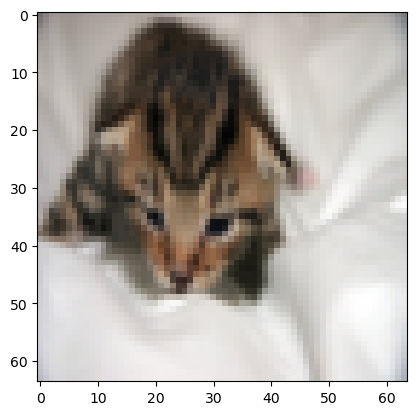

In [75]:
# testing

index = 1
plt.imshow(test_set_x_orig[index])
print(f"predicted result is {y_predicted[:,index] == test_set_y_orig[:,index]}")

<b>Analysis</b>

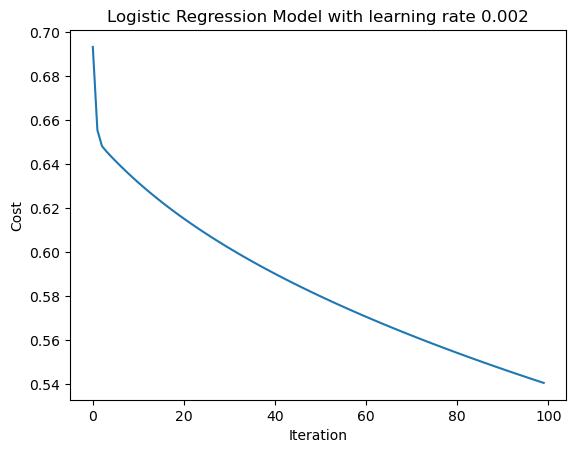

In [82]:
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title(f'Logistic Regression Model with learning rate {learning_rate}')
plt.show()

the 1 epoch's cost: 0.6931471805599453
the 11 epoch's cost: 2.185972314195424
the 21 epoch's cost: nan
the 31 epoch's cost: 42.34651576208458
the 41 epoch's cost: 4.626565232550177


/var/folders/89/vc8w_4y17m9fjk_xpfh7jv1m0000gn/T/ipykernel_24895/3193997685.py:21: RuntimeWarning: divide by zero encountered in log
  loss = -y * np.log(fx) - (1-y) * np.log(1-fx)
/var/folders/89/vc8w_4y17m9fjk_xpfh7jv1m0000gn/T/ipykernel_24895/3193997685.py:21: RuntimeWarning: invalid value encountered in multiply
  loss = -y * np.log(fx) - (1-y) * np.log(1-fx)


the 51 epoch's cost: nan
the 61 epoch's cost: 35.27578921200132
the 71 epoch's cost: 2.973967591747544
the 81 epoch's cost: nan
the 91 epoch's cost: 33.2632187079969


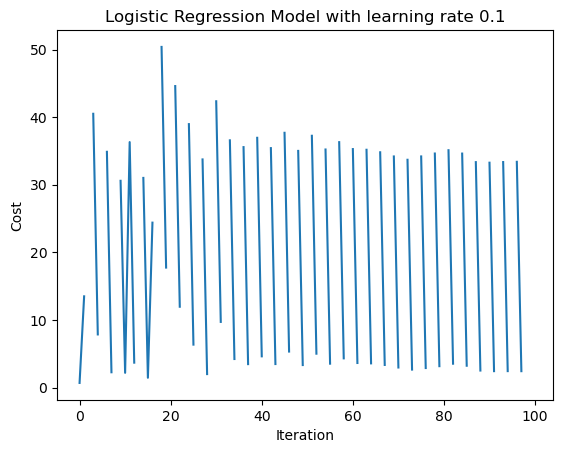

the 1 epoch's cost: 0.6931471805599453
the 11 epoch's cost: 0.8963714956694488
the 21 epoch's cost: 2.7072885611335247
the 31 epoch's cost: 3.8452583416467427
the 41 epoch's cost: 0.6572793346681004
the 51 epoch's cost: 1.2739417398043744
the 61 epoch's cost: 0.5285390252214136
the 71 epoch's cost: 3.3437424372630806
the 81 epoch's cost: 1.097516179953901
the 91 epoch's cost: 0.4584838403505799


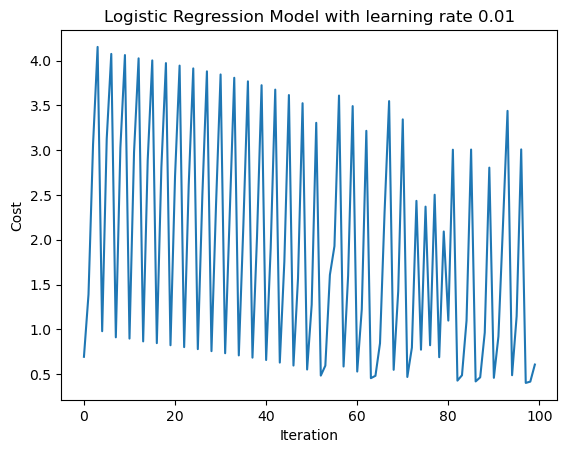

the 1 epoch's cost: 0.6931471805599453
the 11 epoch's cost: 0.641297365621243
the 21 epoch's cost: 0.6315255767603825
the 31 epoch's cost: 0.6229028342275628
the 41 epoch's cost: 0.615173504014457
the 51 epoch's cost: 0.6081506165034397
the 61 epoch's cost: 0.6016961756166475
the 71 epoch's cost: 0.5957071413979085
the 81 epoch's cost: 0.5901055486736324
the 91 epoch's cost: 0.5848315584170467


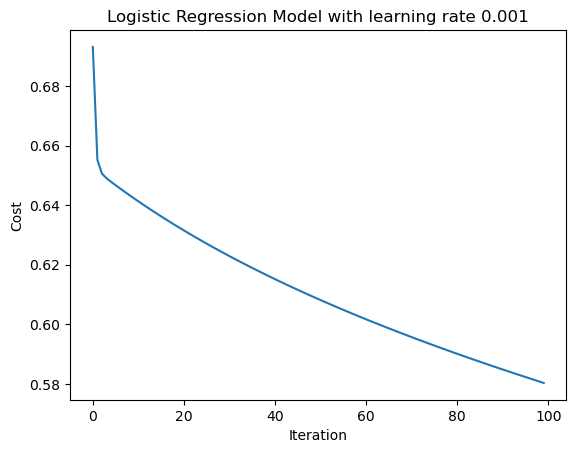

In [83]:
# choose different learning rate
learning_rate_list = [0.1, 0.01, 0.001]
for i in range(len(learning_rate_list)):
    best_W, best_b, cost_history = optimize(train_set_x, train_set_y, W, b, learning_rate_list[i], iteration_number, propagation)
    plt.plot(cost_history)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title(f'Logistic Regression Model with learning rate {learning_rate_list[i]}')
    plt.show()